# Fake News Detection

**Classify news as real or fake using NLP and machine learning.**

## Steps

1. Load labeled news data
2. Clean text and apply TF-IDF
3. Train Logistic Regression
4. Predict new articles

## Libraries

`pandas`, `numpy`, `scikit-learn`, `nltk`, `re`

## Learnings

* Text preprocessing
* TF-IDF features
* Model building & evaluation

[Download Dataset from Google Drive](https://drive.google.com/file/d/1xLoxRDeXiqnwg8nrrCP_iBsUtbP6ulI4/view?usp=sharing)


In [81]:
# Importing necessary libraries:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [3]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mbmoh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# printing the stopwords in english

print(stopwords.words("english"))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [5]:
data = pd.read_csv("train.csv")

print(data.head(1))
print('-'*100)
print(data.info())
print("-" * 100)
print(data.shape)
print("-" * 100)
data["label"].value_counts()
print("-" * 100)
print(data.isnull().sum()) # Null values found in Title and Author columns
print("-" * 100)
print(data.duplicated().sum()) # No duplicate values found

   id                                              title         author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...  Darrell Lucus   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB
None
----------------------------------------------------------------------------------------------------
(20800, 5)
-----------------------------------------------------------------------------------------------

In [6]:
# Replacing the null values:

# Drop rows with missing 'text'
data = data.dropna(subset=["text"])

# Fill 'title' and 'author' with placeholders
data["title"] = data["title"].fillna("")
data["author"] = data["author"].fillna("unknown")

In [7]:
print(data.isnull().sum()) # No null values now

id        0
title     0
author    0
text      0
label     0
dtype: int64


In [8]:
# Merging the author name and title with the text column:

data["content"] = data["author"] + " " + data["title"] + " " + data["text"]

In [9]:
print(data['content'])

0        Darrell Lucus House Dem Aide: We Didn’t Even S...
1        Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2        Consortiumnews.com Why the Truth Might Get You...
3        Jessica Purkiss 15 Civilians Killed In Single ...
4        Howard Portnoy Iranian woman jailed for fictio...
                               ...                        
20795    Jerome Hudson Rapper T.I.: Trump a ’Poster Chi...
20796    Benjamin Hoffman N.F.L. Playoffs: Schedule, Ma...
20797    Michael J. de la Merced and Rachel Abrams Macy...
20798    Alex Ansary NATO, Russia To Hold Parallel Exer...
20799    David Swanson What Keeps the F-35 Alive   Davi...
Name: content, Length: 20761, dtype: object


In [42]:
# Features and target
X = data["content"]  # Only the combined text
y = data["label"]

print(X.head())
print("-" * 100)
print(y.head())

0    Darrell Lucus House Dem Aide: We Didn’t Even S...
1    Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2    Consortiumnews.com Why the Truth Might Get You...
3    Jessica Purkiss 15 Civilians Killed In Single ...
4    Howard Portnoy Iranian woman jailed for fictio...
Name: content, dtype: object
----------------------------------------------------------------------------------------------------
0    1
1    0
2    1
3    1
4    1
Name: label, dtype: int64


In [43]:
port_stem = PorterStemmer()
stop_words = set(stopwords.words("english"))


def stemming(content):
    
    # Keep only letters
    content = re.sub("[^a-zA-Z]", " ", content)

    # Lowercase and split
    words = content.lower().split()

    # Remove stopwords and stem
    stemmed_words = [port_stem.stem(word) for word in words if word not in stop_words]
    return " ".join(stemmed_words)


# Apply to the content column
X = X.apply(stemming)
print(X.head())

0    darrel lucu hous dem aid even see comey letter...
1    daniel j flynn flynn hillari clinton big woman...
2    consortiumnew com truth might get fire truth m...
3    jessica purkiss civilian kill singl us airstri...
4    howard portnoy iranian woman jail fiction unpu...
Name: content, dtype: object


In [49]:
# Apply stemming and store it back in the DataFrame
data["content"] = data["content"].apply(stemming)

In [50]:
# Seaparating the data into labels and features:

X = data["content"].values
y = data["label"].values


In [52]:
print(X[:5])
print("-" * 100)
print(y[:5])

['darrel lucu hous dem aid even see comey letter jason chaffetz tweet hous dem aid even see comey letter jason chaffetz tweet darrel lucu octob subscrib jason chaffetz stump american fork utah imag courtesi michael jolley avail creativ common licens apolog keith olbermann doubt worst person world week fbi director jame comey accord hous democrat aid look like also know second worst person well turn comey sent infam letter announc fbi look email may relat hillari clinton email server rank democrat relev committe hear comey found via tweet one republican committe chairmen know comey notifi republican chairmen democrat rank member hous intellig judiciari oversight committe agenc review email recent discov order see contain classifi inform long letter went oversight committe chairman jason chaffetz set polit world ablaz tweet fbi dir inform fbi learn exist email appear pertin investig case reopen jason chaffetz jasoninthehous octob cours know case comey actual say review email light unrel 

In [53]:
# Converting the text data to feature vectors that can be used as input to the Logistic Regression model:

vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)
print(X)


  (0, 325)	0.043523055174034764
  (0, 521)	0.02297253657401515
  (0, 634)	0.038709194444558406
  (0, 872)	0.01573077398294535
  (0, 921)	0.01638812872030479
  (0, 1297)	0.021075350349882324
  (0, 1609)	0.01797589681166544
  (0, 1885)	0.11543210731958752
  (0, 3020)	0.046606090488443226
  (0, 3040)	0.019008010562198228
  (0, 3375)	0.011790829569795937
  (0, 3741)	0.030880228265956787
  (0, 4154)	0.016674949997306048
  (0, 4258)	0.019417848920570878
  (0, 4304)	0.026423872436219877
  (0, 4586)	0.017691617659549297
  (0, 4769)	0.025938176311206287
  (0, 4819)	0.04167778778322374
  (0, 4836)	0.014396103725032989
  (0, 6418)	0.01822108229505636
  (0, 6961)	0.020646535207557562
  (0, 8552)	0.021640854082163763
  (0, 9066)	0.014231681204567595
  (0, 10840)	0.04759181302394684
  (0, 12244)	0.02777843030143807
  :	:
  (20760, 106787)	0.036572478573005836
  (20760, 106920)	0.04920650004321594
  (20760, 107241)	0.01865178384444874
  (20760, 107275)	0.04313637923285733
  (20760, 107602)	0.01739785

In [54]:
# Splitting the dataset into training and testing data:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)
print(X.shape, X_train.shape, X_test.shape)



(20761, 111458) (16608, 111458) (4153, 111458)


# Logistic Regression Model

Predicted labels on training set: [0 1 1 ... 0 1 0]
True labels on training set: [0 1 1 ... 0 1 0]
Accuracy on training set: 97.98% 
Predicted labels on test set: [1 0 1 ... 1 1 1]
True labels on test set: [1 0 1 ... 1 1 1]
Accuracy on testing set: 96.08% 
[[1990   88]
 [  75 2000]]


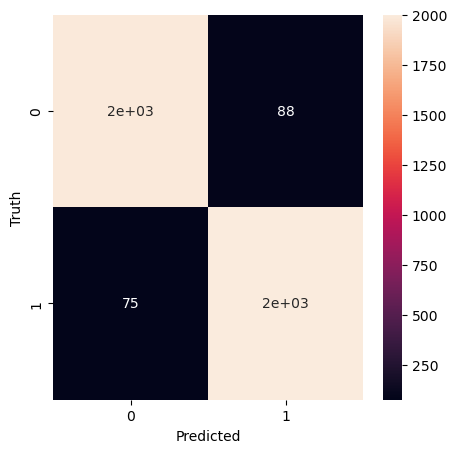

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2078
           1       0.96      0.96      0.96      2075

    accuracy                           0.96      4153
   macro avg       0.96      0.96      0.96      4153
weighted avg       0.96      0.96      0.96      4153



In [64]:
# Training the Logistic Regression model:

model = LogisticRegression()
model.fit(X_train, y_train)

# Prediction on the training data:
X_train_pred = model.predict(X_train)
print("Predicted labels on training set:", X_train_pred)
print("True labels on training set:", y_train)  # True labels
print(f"Accuracy on training set: {accuracy_score(y_train, X_train_pred)*100:.2f}% ")


# Predicting the labels for the test set:
y_pred = model.predict(X_test)
print("Predicted labels on test set:", y_pred)
print("True labels on test set:", y_test)  # True labels
print(f"Accuracy on testing set: {accuracy_score(y_test, y_pred)*100:.2f}% ")

# Evaluating the model:
print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()
print(classification_report(y_test, y_pred))

Building a predictive system:

In [79]:
# Building a predictive system:

X_new = X_test[3]

prediction = model.predict(X_new)
print(prediction)
if prediction[0] == 0:
    print("The news is Real")
else:
    print("The news is Fake")

[1]
The news is Fake


In [ ]:
print(y_test[3])

1


# Random Forest Classifier

Predicted labels on training set: [0 1 1 ... 0 1 0]
True labels on training set: [0 1 1 ... 0 1 0]
Accuracy on training set: 100.00% 
Predicted labels on test set: [1 1 1 ... 1 1 1]
True labels on test set: [1 0 1 ... 1 1 1]
Accuracy on testing set: 93.33% 
[[1994   84]
 [ 193 1882]]


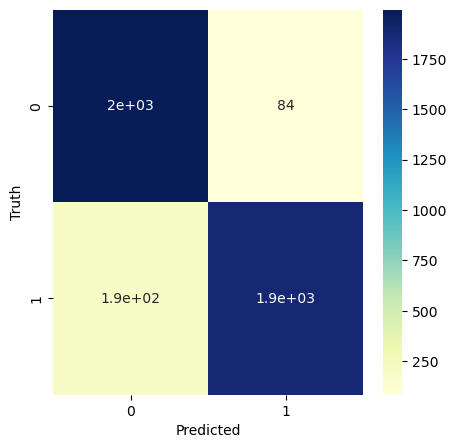

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2078
           1       0.96      0.91      0.93      2075

    accuracy                           0.93      4153
   macro avg       0.93      0.93      0.93      4153
weighted avg       0.93      0.93      0.93      4153



In [72]:
# Random Forest Classifier:

rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
rf_y_pred = rf_classifier.predict(X_test)

# Training data
rf_X_train_pred = rf_classifier.predict(X_train)
print("Predicted labels on training set:", rf_X_train_pred)
print("True labels on training set:", y_train)  # True labels
print(f"Accuracy on training set: {accuracy_score(y_train, rf_X_train_pred)*100:.2f}% ")


# Testing data
print("Predicted labels on test set:", rf_y_pred)
print("True labels on test set:", y_test)  # True labels
print(f"Accuracy on testing set: {accuracy_score(y_test, rf_y_pred)*100:.2f}% ")

print(confusion_matrix(y_test, rf_y_pred))

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix(y_test, rf_y_pred), annot=True, cmap ="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()

print(classification_report(y_test, rf_y_pred))



# Naive Bayes Model

Predicted labels on training set: [0 1 1 ... 0 0 0]
True labels on training set: [0 1 1 ... 0 1 0]
Accuracy on training set: 91.50% 
Predicted labels on test set: [0 0 1 ... 1 1 1]
True labels on test set: [1 0 1 ... 1 1 1]
Accuracy on testing set: 88.20% 
[[2055   23]
 [ 467 1608]]


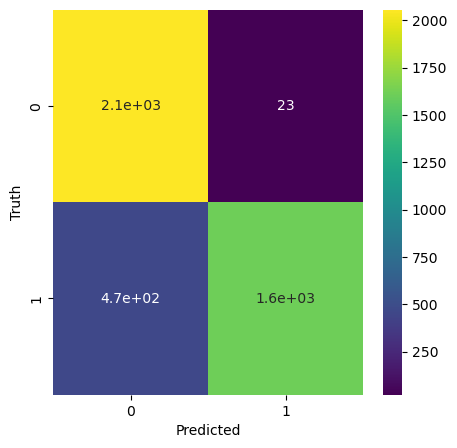

              precision    recall  f1-score   support

           0       0.81      0.99      0.89      2078
           1       0.99      0.77      0.87      2075

    accuracy                           0.88      4153
   macro avg       0.90      0.88      0.88      4153
weighted avg       0.90      0.88      0.88      4153



In [71]:
# Naive Bayes Classifier:

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
nb_y_pred = nb_classifier.predict(X_test)

# Training data
nb_X_train_pred = nb_classifier.predict(X_train)
print("Predicted labels on training set:", nb_X_train_pred)
print("True labels on training set:", y_train)  # True labels
print(f"Accuracy on training set: {accuracy_score(y_train, nb_X_train_pred)*100:.2f}% ")

# Testing data
print("Predicted labels on test set:", nb_y_pred)
print("True labels on test set:", y_test)  # True labels
print(f"Accuracy on testing set: {accuracy_score(y_test, nb_y_pred)*100:.2f}% ")

print(confusion_matrix(y_test, nb_y_pred))

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix(y_test, nb_y_pred), annot=True, cmap = 'viridis')
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()

print(classification_report(y_test, nb_y_pred))

# XGBoost Classifier

Predicted labels on training set: [0 1 1 ... 0 1 0]
True labels on training set: [0 1 1 ... 0 1 0]
Accuracy on training set: 99.98% 
Predicted labels on test set: [1 0 1 ... 1 1 1]
True labels on test set: [1 0 1 ... 1 1 1]
Accuracy on testing set: 98.15% 
[[2041   37]
 [  40 2035]]


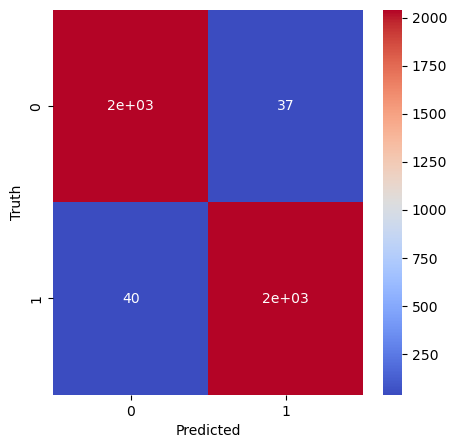

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2078
           1       0.98      0.98      0.98      2075

    accuracy                           0.98      4153
   macro avg       0.98      0.98      0.98      4153
weighted avg       0.98      0.98      0.98      4153



In [70]:
# XGBoost Classifier:

xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train)
xgb_y_pred = xgb_classifier.predict(X_test)

# Training data
xgb_X_train_pred = xgb_classifier.predict(X_train)
print("Predicted labels on training set:", xgb_X_train_pred)
print("True labels on training set:", y_train)  # True labels
print(f"Accuracy on training set: {accuracy_score(y_train, xgb_X_train_pred)*100:.2f}% ")

# Testing data
print("Predicted labels on test set:", xgb_y_pred)
print("True labels on test set:", y_test)  # True labels
print(f"Accuracy on testing set: {accuracy_score(y_test, xgb_y_pred)*100:.2f}% ") 

print(confusion_matrix(y_test, xgb_y_pred))

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix(y_test, xgb_y_pred), annot=True, cmap="coolwarm")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()

print(classification_report(y_test, xgb_y_pred))